In [1]:
from walsh import * 
from scipy.fft import fft, ifft
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [2]:
def time_evolution(n, K, terms_kept=None):
    # Constants
    hbar = 1.0  # Reduced Planck's constant
    m = 1.0     # Mass of the particle

    # Problem setup
    T = .6
    N = 2**n
    x0 = -3.0  # Initial position
    p0 = 15.0  # Initial momentum
    sigma = 0.5
    L = 5    # Spatial domain [-L, L]

    def initial_wave_function(x, x0, sigma, p0):
        return np.exp(-(x - x0)**2 / (2 * sigma**2) + 1j*p0*(x - x0))

    potential = lambda x: 100/np.cosh(x/.5)

    x_grid = np.linspace(-L, L, N)
    t_grid = np.linspace(0, T, K)   
    dx, dt = x_grid[1] - x_grid[0], t_grid[1] - t_grid[0]

    # Initialize the initial wave function
    desired_vector = initial_wave_function(x_grid, x0, sigma, p0)
    psi = desired_vector/np.linalg.norm(desired_vector)

    a = wft(potential, n, x_grid)
    potential_walsh = iwft(a, n, terms_kept=terms_kept)

    amplitudes = []
    progress = tqdm(total=K, desc='working on time evolution')
    for i in range(K):
        # Propogate potential
        psi = psi*np.exp(-1j*potential_walsh*dt/hbar)

        # Propogate kinetic              
        psi = fft(psi)
        p = 2 * np.pi * np.fft.fftfreq(N, d=dx)  # Momentum grid
        psi = psi*np.exp(-1j*dt*hbar*p**2/(2*m))
        psi = ifft(psi)

        amplitudes.append(np.abs(psi)**2)
        progress.update(1)
    progress.close()
    amplitudes = np.array(amplitudes)/dx
    return amplitudes, t_grid, x_grid

In [3]:
def plot_time_evolution(amplitudes, t_grid, x_grid, interpolate_plot=True):
    T, X = np.meshgrid(t_grid, x_grid)
    C = amplitudes.T

    if interpolate_plot:
        grid_size = 1000
        t_interp, x_interp = np.linspace(T[0, 0], T[0, -1], grid_size), np.linspace(X[0, 0], X[-1, 0], grid_size)
        T_new, X_new = np.meshgrid(t_interp, x_interp)
        interp = RegularGridInterpolator((T[0, :], X[:, 0]), C.T, method='linear')
        plt.pcolor(T_new, -X_new, interp((T_new, X_new)), cmap='magma')
        plt.show()
    else:
        plt.pcolor(T, -X, C, cmap='magma')
        plt.yticks([-5, 0, 5], [5, 0, -5])
        plt.show()

working on time evolution: 100%|██████████| 10000/10000 [00:01<00:00, 8489.05it/s]


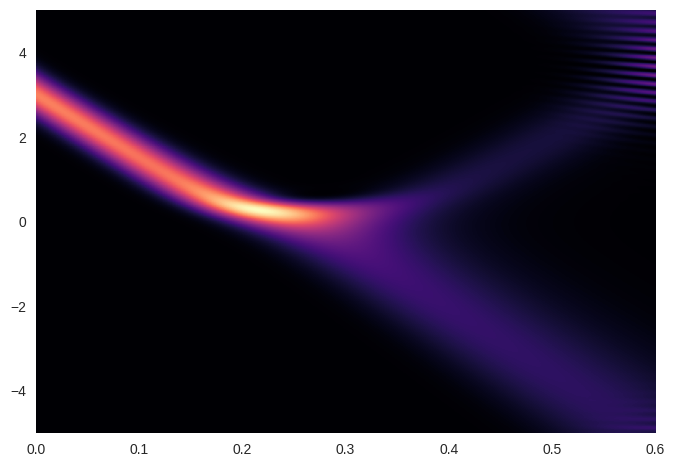

In [4]:
amplitudes, t_grid, x_grid = time_evolution(10, 10000, terms_kept=None)
plot_time_evolution(amplitudes, t_grid, x_grid)

In [5]:
n_true = 12
true = time_evolution(n_true, 15000)[0][-1, :]
final_waves = []

n_vals, K_vals = [7, 8, 9, 10, 11], [2500, 5000, 7500, 10000, 12500]
for n, K in zip(n_vals, K_vals):
    amplitudes, t_grid, x_grid = time_evolution(n, K, terms_kept=None)
    final_waves.append(amplitudes[-1, :])

working on time evolution: 100%|██████████| 12500/12500 [00:01<00:00, 7219.43it/s]


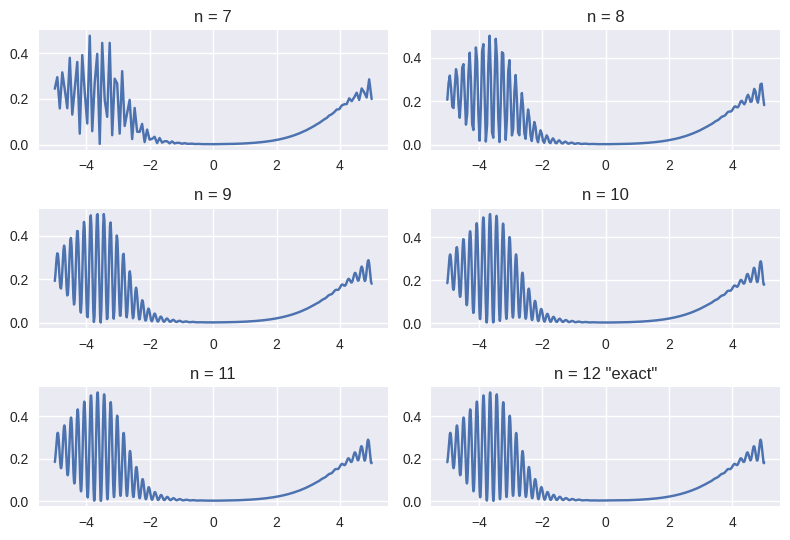

In [6]:
fig, ax = plt.subplots(3, 2)
ax = ax.ravel() 
final_errors = []
for entry, i in zip(final_waves, range(len(final_waves))):
    final_errors.append(np.linalg.norm(entry[::2**i] - true[::2**(n_true - min(n_vals))]))
    x_entry = np.linspace(-5, 5, len(entry))
    ax[i].plot(x_entry, entry)
    ax[i].set_title(f'n = {n_vals[i]}')
x_true = np.linspace(-5, 5, 2**n_true)
ax[-1].plot(x_true, true, label=n_true)
ax[-1].set_title(f'n = {n_true} \"exact\"')
plt.tight_layout()
plt.show()

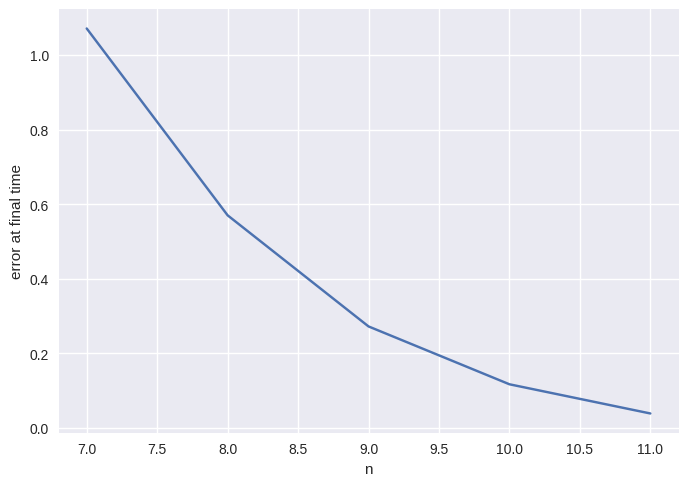

In [7]:
plt.plot(n_vals, final_errors)
plt.xlabel('n')
plt.ylabel('error at final time')
plt.show()